In [1]:
from utils.bigquery_handler import BigQueryHandler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
bqh = BigQueryHandler('unir-predictiv0-andina-espana')

query = f"""
    SELECT fecha, sum(dolares) as dolares
    FROM `unir-predictiv0-andina-espana.datacomex.comex_comunidad_andina_modelo` 
    where nivel_taric = '1' AND cod_taric = '27' AND tipo_movimiento_cod = 'I'
    group by fecha
"""

df = bqh.get_bigquery_data(query)

c:\Users\USUARIO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0710 - mae: 0.1446 - val_loss: 0.0115 - val_mae: 0.0872
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0348 - mae: 0.1344 - val_loss: 0.0211 - val_mae: 0.1238
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0277 - mae: 0.1207 - val_loss: 0.0111 - val_mae: 0.0863
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0240 - mae: 0.0857 - val_loss: 0.0119 - val_mae: 0.0924
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0154 - mae: 0.0715 - val_loss: 0.0214 - val_mae: 0.1263
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0259 - mae: 0.0943 - val_loss: 0.0112 - val_mae: 0.0899
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0169 - mae: 0.0661 - val_loss: 0.0120 - val_mae: 0.0933
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0129 - mae: 0.0650 - val_loss: 0.0179 - val_mae: 0.1150
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0149 - mae: 0.0729 - 

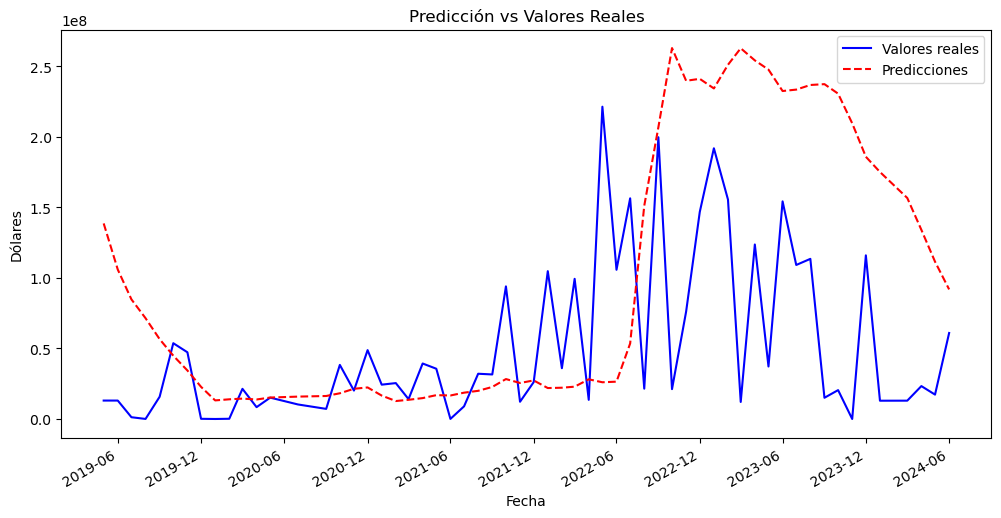

In [4]:
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values(by='fecha')

data = df['dolares'].values

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(data_scaled, time_steps)

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

model = Sequential([
    LSTM(256, activation='relu', input_shape=(time_steps, X.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(128, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss: {loss}, MAE: {mae}")

last_sequence = X_test[-1]
last_sequence = np.expand_dims(last_sequence, axis=0)
prediccion_escalada = model.predict(last_sequence)
prediccion_original = scaler.inverse_transform(prediccion_escalada)
print(f"Predicción para el siguiente valor: {prediccion_original[0, 0]}")


y_pred = model.predict(X_test)

import matplotlib.dates as mdates

y_test_original = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), 2)))))[:, 0]
y_pred_original = scaler.inverse_transform(np.hstack((y_pred, np.zeros((len(y_pred), 2)))))[:, 0]

fechas_test = df['fecha'].iloc[-len(y_test):]


plt.figure(figsize=(12, 6))
plt.plot(fechas_test, y_test_original, label="Valores reales", color="blue")
plt.plot(fechas_test, y_pred_original, label="Predicciones", color="red", linestyle="dashed")
plt.title("Predicción vs Valores Reales")
plt.xlabel("Fecha")
plt.ylabel("Dólares")
plt.legend()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()
plt.show()
